In [1]:
import SLMlayout as Layout
from SLMlayout.functions import simulate_Fourier_filtering
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib notebook

## Define useful function for simulating spatial frequency filtering

We want to generate binary amplitude masks that will end up, after a 4-f imaging system and filtering in the Fourier plane, in an amplitude and phase modulation on each macropixel. The Lee hologram method is detailed [here](http://wavefrontshaping.net/index.php/component/content/article/57-community/tutorials/spatial-lights-modulators-slms/70-how-to-get-amplitude-and-phase-modulation-using-a-binary-amplitude-deformable-miror-device-dmd).



![equivalent setup](./setup.png)

## Create Layout

We test here an hexagonal layout with a total radius of 140 pixels, a size of hexagonal macropixels of 20 pixels and a typical gap inbetween of 3 pixels.

2020-07-21 10:25:51,590 - SLMlayout.layouts. [INFO   ]  Creation of the hexagonal layout
2020-07-21 10:25:51,591 - SLMlayout.layouts. [DEBUG  ]  Creation of the unique cell
2020-07-21 10:25:51,593 - SLMlayout.layouts. [DEBUG  ]  Setting up the grid
2020-07-21 10:25:51,810 - SLMlayout.layouts. [INFO   ]  -> Number of segments = 121
2020-07-21 10:25:51,811 - SLMlayout.layouts. [DEBUG  ]  Sorting segments accoring to distance from center (default)


<IPython.core.display.Javascript object>


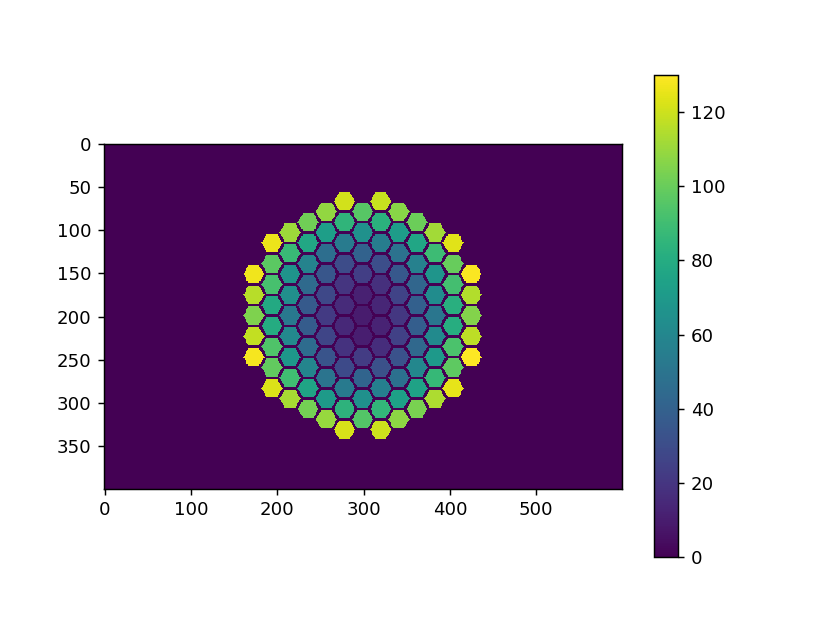

In [3]:
layout = Layout.Hexagons(radius = 140, 
                         cellSize = 21,
                         resolution = [400,600], 
                         center = [400//2,600//2], 
                         gap = 3)
#Display the layout, colors are for representation only.
layout.showLayout()

### Generation amplitude and phase desired complex pattern

In [4]:
# period of the Lee Hologram
period = 8
# Orientation of the fringes
angle = np.pi/4

## Generate a list of complex values corresponding to the complex amplitude we want on each macropixel.

# amplitude on each element, increasing between 0 and 1 from center to border of the illumination.
vec = np.linspace(0,1,layout.nParts).astype(complex) 

# phase of the elements, phase varies as the angular position of the macropixels
idx = layout.sortSegments(order = 'angles', rearrange = False)
vec[idx] *= np.exp(1j*np.linspace(0,1,layout.nParts)*2*np.pi)

Layout allows us to get the complex target field from the list of values

<IPython.core.display.Javascript object>


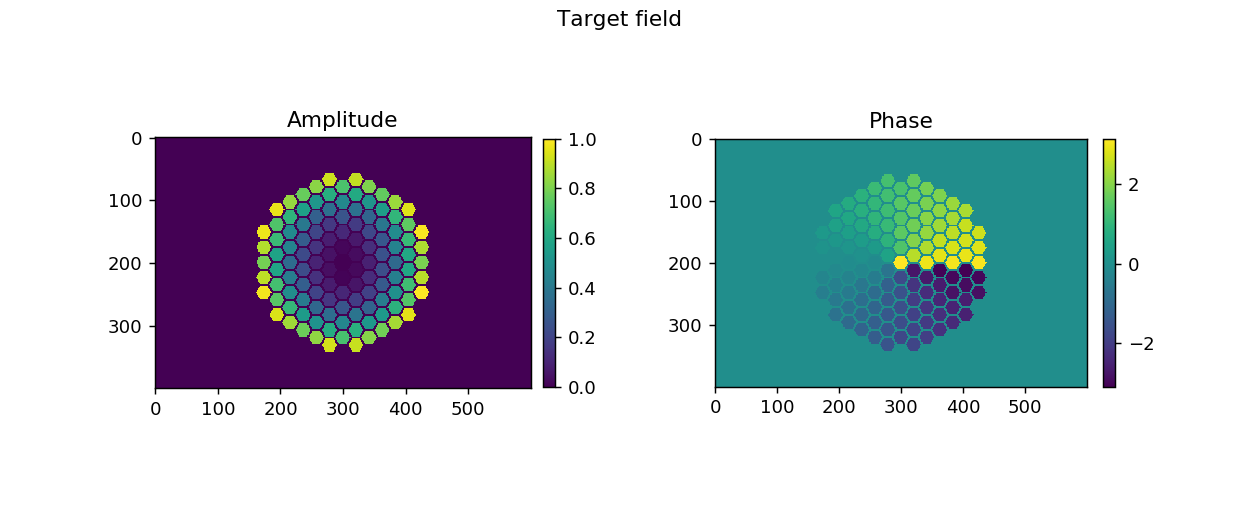

Text(0.5, 1.0, 'Phase')

In [5]:
img_amp = layout.getImageFromVec(vec,dtype=np.complex)

plt.figure(figsize=[9.5,4])
plt.suptitle('Target field')
plt.subplot(121)
plt.subplots_adjust(wspace = 0.4)
plt.imshow(np.abs(img_amp))
plt.colorbar(fraction=0.031, pad=0.03)
plt.title('Amplitude')
plt.subplot(122)
plt.imshow(np.angle(img_amp))
plt.colorbar(fraction=0.031, pad=0.04)
plt.title('Phase')

### Bitplanes

Layout allows generating bitplane, binary images 8 types smaller than full resolution 8 bit images that can be sent to the DMD using [ALP4lib](https://github.com/wavefrontshaping/ALP4lib) when using [Vialux](https://www.vialux.de/en/) DMDs.


In [6]:
bitplane = layout.getBitPlaneFromVec(vec,leePeriod = period, angle = angle)

This bitplane can be converted back to numpy array for an easy visusalisation of the mask to be displayed.

<IPython.core.display.Javascript object>


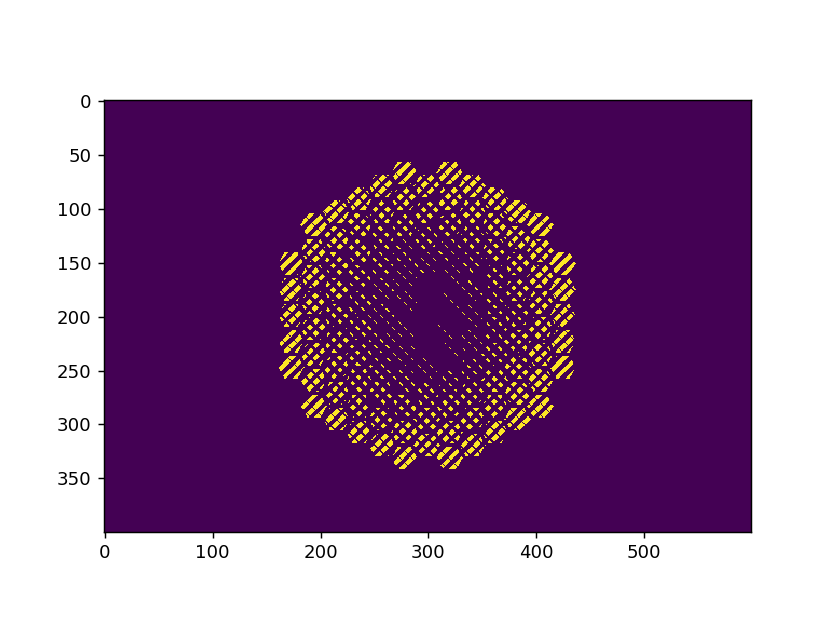

In [7]:
mask = layout.getMaskFromBitPlane(bitplane)

plt.figure()
plt.imshow(mask)

### Direct generation of masks

We can also generate 8-bit masks directly without using bitplanes. Note that when the bitplane feature is supported by the DMD, this is not the most efficient way as the calculation is longer, and images to send on the DMD are 8 times bigger, resulting in significantly greater loading times.
Note also that this function is not yet optimized for fast .

<IPython.core.display.Javascript object>


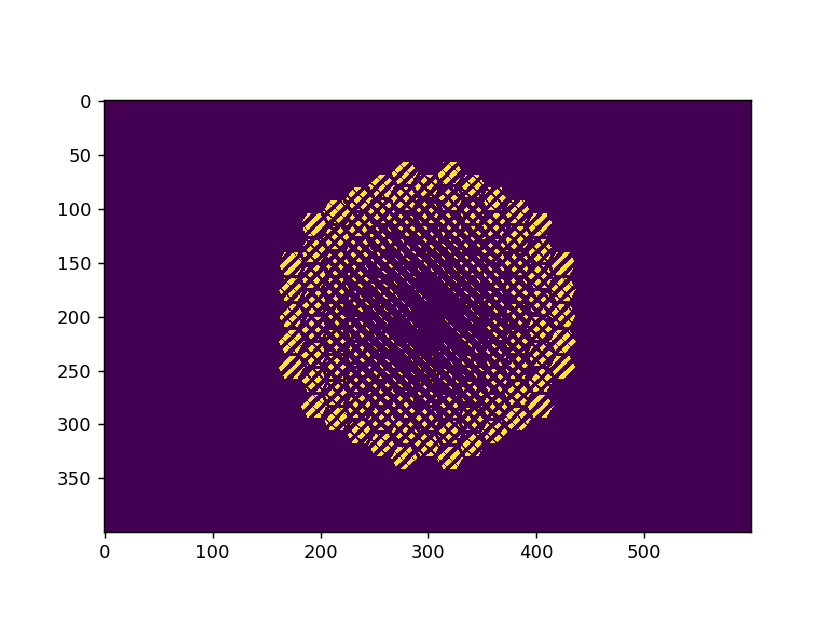

In [8]:
mask2 = layout.getMaskFromImage(img_amp,leePeriod = period,angle = angle)

plt.figure()
plt.imshow(mask2)

## Claculation of the theoretical resulting field after filtering

<IPython.core.display.Javascript object>


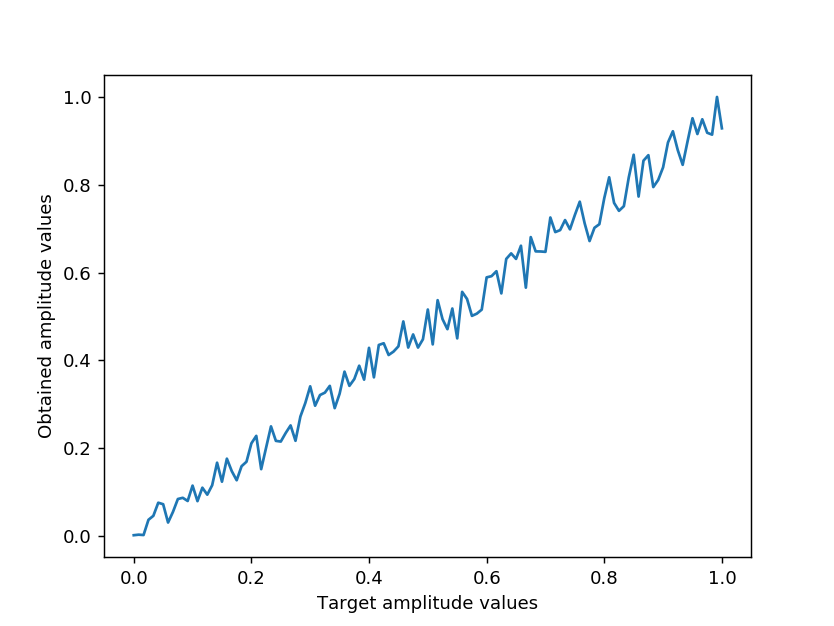

<IPython.core.display.Javascript object>


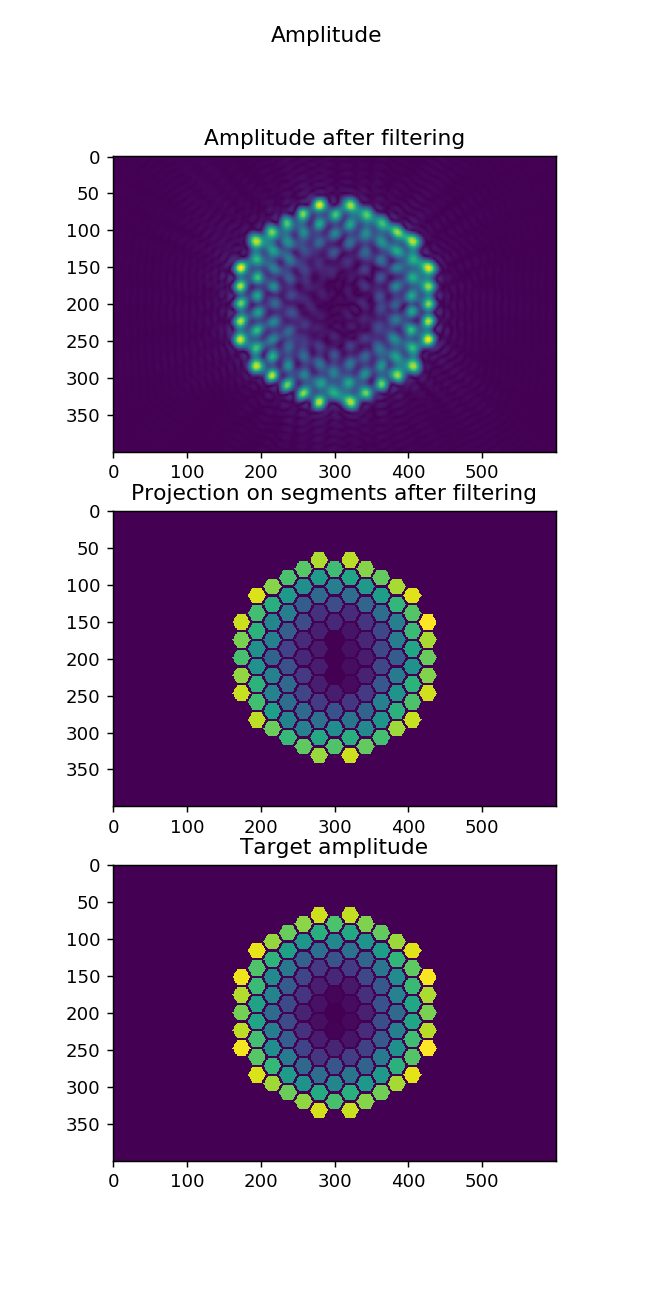

<IPython.core.display.Javascript object>


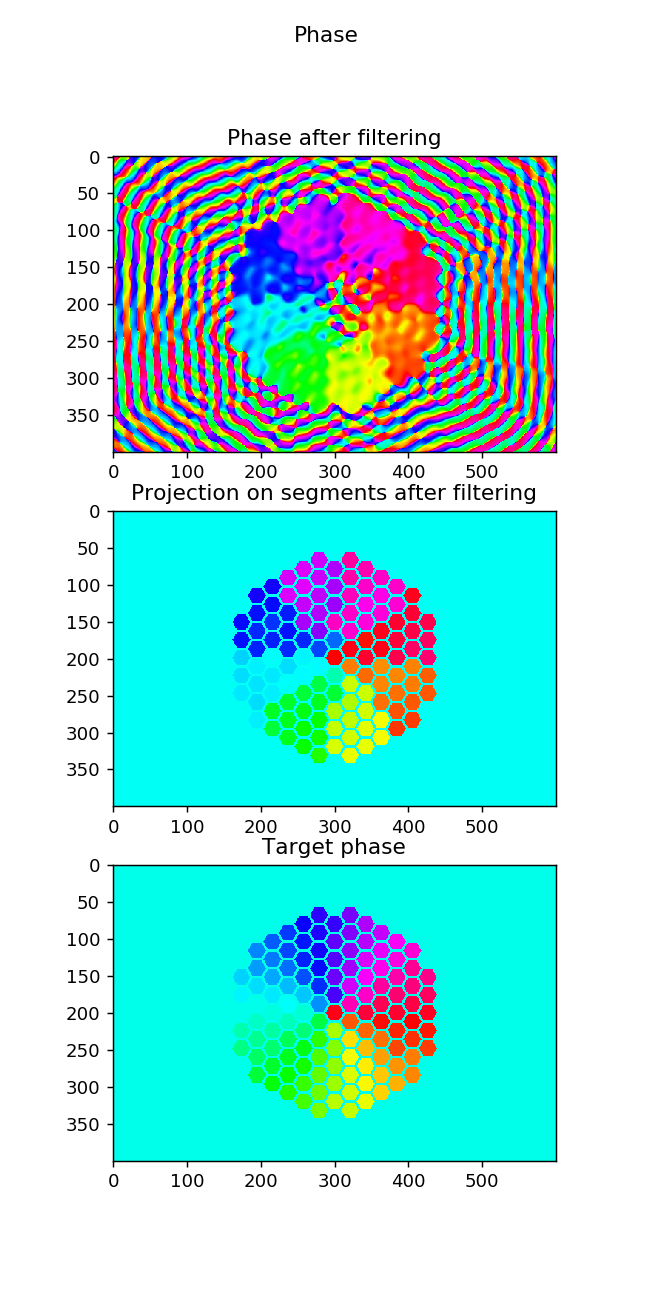

Text(0.5, 1.0, 'Target phase')

In [9]:
# We will calculate the FFT with 4 times more points than the size of the image for better results
coeff = 4

# Calculate the resulting field for a pinhole centered around the 1st diffraction order of the Lee grating
# we can change the filter size with window_fft_width.
filt = simulate_Fourier_filtering(
    mask, 
    center_fft = [np.sin(angle)/period,np.cos(angle)/period], 
    window_fft_width = 0.1, 
    fft_zoom = coeff
)

# To compensage for a global phase shift 
# (that is purely without consequence, we compensate for it for visualization purposes):
filt *= np.exp(1j*-np.angle(filt[tuple(zip(*[layout.getCenters(-1)]))])) \
            * np.exp(1j*np.angle(img_amp[tuple(zip(*[layout.getCenters(-1)]))]))


# Get the amplitude projected onto the hexagonal base
projections = layout.getProjections(filt,method = 'average')
projections = projections/np.max(np.abs(projections))

# Generate the image corresponding to the projection vector.
filt_proj = layout.getImageFromVec(projections,dtype = np.complex)

plt.figure()
plt.plot(np.abs(vec),np.abs(projections))
plt.xlabel('Target amplitude values')
plt.ylabel('Obtained amplitude values')


plt.figure(figsize = [5,10])
plt.suptitle('Amplitude')
plt.subplot(311)
plt.imshow(np.abs(filt)/np.max(np.abs(filt)))
plt.title('Amplitude after filtering')
plt.subplot(312)
plt.imshow(np.abs(filt_proj)/np.max(np.abs(filt_proj)))
plt.title('Projection on segments after filtering')
plt.subplot(313)
plt.imshow(np.abs(img_amp))
plt.title('Target amplitude')



plt.figure(figsize = [5,10])
plt.suptitle('Phase')
plt.subplot(311)
plt.imshow(np.angle(filt),cmap='hsv')
plt.title('Phase after filtering')
plt.subplot(312)
plt.imshow(np.angle(filt_proj),cmap='hsv')
plt.title('Projection on segments after filtering')
plt.subplot(313)
plt.imshow(np.angle(img_amp),cmap='hsv')
plt.title('Target phase')
